In [1]:
import os
from functools import lru_cache
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from uncertainties import ufloat
import dataframe_image as dfi
import mlflow
from mlflow.tracking import MlflowClient
mlflow.set_tracking_uri('file:///home/zeyusun/work/flare-prediction-smarp/mlruns')
client = MlflowClient()

from mlflow_helper import *
from cotrain_helper import run_meta_learn, meta_learn_show_results, meta_learn_show_instance
retrieve = lru_cache(retrieve)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

/home/zeyusun/.conda/envs/arnet3/lib/python3.8/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)
/home/zeyusun/work/flare-prediction-smarp/arnet/constants.py:25: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  CONSTANTS = get_constants()


In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

* Goal: this notebook showcases the results. Keep it concise.
* Pipeline
    * Train the models: `python sweep_arnet.py`
    * Run the evaluations. 
    * Do I need to save the predictions? Yes. Otherwise, you need to retrieve the model and do the inference all over again for all settings.
        * Curves with error bars needs multiple test results.
* Task:
    * ~~[ ] Sec 4.1-4.3. Balanced~~
    * [ ] Sec 4.1-4.3. Imbalanced
        * [ ] Sec 4.1-4.3. balanced
        * [ ] Sec 4.1-4.3. Adjusted
        * [ ] Sec 4.1-4.3. RD corrected
    * [ ] Sec 4.4
* Should val be rus?
    * Val should not be RUS.
        * It selects the best model for the test set.
        * Stacking: optimal weights for test
* Problem
    * If you are going to use transfer learning approach to adjust the predicted probabilities, then in model training, the early-stopping metrics should be calculated using the *adjusted* predicted probability.

**Minimum things**
* [ ] ~~Report the imbalanced results in the paper~~
    * [ ] ~~Report the adjusted results in the paper~~: Too much. Not all 3 claims still holds.
* [ ] Stick to the undersampled results in the paper.
* [ ] Give realistic evaluation results in the response.
    * [ ] class imbalance
* [ ] Remove all hero's edits in the paper

In [3]:
def correct_prob(probs, labels):
    p1_a, p1_b = 0.5, np.mean(labels)
    w1, w0 = p1_b / p1_a, (1-p1_b) / (1-p1_a)
    probs = w1 * probs / (w1 * probs + w0 * (1 - probs))
    return probs

In [7]:
base_exp_name = 'leaderboard8'
base_run_name, meta_run_name, output_dir, correct_prob = (
    'reproduce_2', 'reproduce_2', 'poster/graphical_rus_2', None
    # 'reproduce_3', 'reproduce_3', 'poster/graphical_unadj', None
    # 'reproduce_3', 'reproduce_3_transfer', 'poster/graphical_transfer', correct_prob
    #'reproduce_4', 'reproduce_4_unadj', 'poster/graphical_4_unadj', None  # no leaderboard8/reproduce_4.
)

## Sec 4.1

### Table 6

In [5]:
def construct_df_run(base_exp_name, base_run_name, correct_prob=None):
    from tqdm import tqdm
    from itertools import product
    from arnet import utils
    
    datasets = ['sharp', 'fused_sharp', 'smarp', 'fused_smarp']
    seeds = [str(i) for i in range(10)]
    estimators = ['LSTM', 'CNN']
    
    results = []
    for dataset, seed, estimator in tqdm(product(datasets, seeds, estimators)):
        labels, probs = get_labels_probs(
            query=f'{base_exp_name}/{base_run_name}/{dataset}/{seed}/None/None/{estimator}',
            split='test',
            correct_prob=correct_prob,
        )
        metrics, _, _ = utils.get_metrics_probabilistic(labels, probs, criterion=None)
        metrics = {k: v.item() for k, v in metrics.items()}
        metrics.update({
            'dataset': dataset,
            'seed': seed,
            'estimator': estimator,
        })
        results.append(metrics)
    runs = pd.DataFrame(results)
    return runs

In [6]:
runs = construct_df_run(base_exp_name, base_run_name, correct_prob=correct_prob)
organize(runs, std=True)

80it [00:05, 15.06it/s]
/home/zeyusun/work/flare-prediction-smarp/notebooks/mlflow_helper.py:105: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  df = (runs


dataset                fused_sharp    fused_smarp          sharp  \
          estimator                                                
precision CNN        0.930+/-0.036  0.908+/-0.030  0.928+/-0.037   
          LSTM       0.943+/-0.013  0.902+/-0.027  0.939+/-0.021   
recall    CNN        0.902+/-0.059  0.892+/-0.067  0.921+/-0.048   
          LSTM       0.962+/-0.027  0.899+/-0.057  0.939+/-0.053   
accuracy  CNN        0.916+/-0.026  0.900+/-0.023  0.924+/-0.013   
          LSTM       0.952+/-0.014  0.900+/-0.025  0.939+/-0.021   
f1        CNN        0.914+/-0.029  0.898+/-0.028  0.923+/-0.014   
          LSTM       0.952+/-0.014  0.899+/-0.027  0.938+/-0.023   
tss       CNN        0.832+/-0.052  0.799+/-0.047  0.847+/-0.026   
          LSTM       0.904+/-0.027  0.800+/-0.050  0.878+/-0.042   
hss1      CNN        0.832+/-0.052  0.799+/-0.047  0.847+/-0.026   
          LSTM       0.904+/-0.027  0.800+/-0.050  0.878+/-0.042   
hss2      CNN        0.832+/-0.052  0.799+/-0.047  0.847+/-0.026   
          LSTM       0.904+/-0.027  0.800+/-0.050  0.878+/-0.042   
auc       CNN        0.977+/-0.010  0.964+/-0.016  0.983+/-0.007   
          LSTM       0.990+/-0.004  0.965+/-0.015  0.987+/-0.005   
bss       CNN        0.661+/-0.111  0.621+/-0.096  0.731+/-0.048   
          LSTM       0.806+/-0.043  0.603+/-0.109  0.772+/-0.065   

dataset                      smarp  
          estimator                 
precision CNN        0.903+/-0.021  
          LSTM       0.894+/-0.017  
recall    CNN        0.868+/-0.073  
          LSTM       0.906+/-0.054  
accuracy  CNN        0.887+/-0.030  
          LSTM       0.899+/-0.025  
f1        CNN        0.883+/-0.036  
          LSTM       0.900+/-0.027  
tss       CNN        0.774+/-0.061  
          LSTM       0.799+/-0.049  
hss1      CNN        0.774+/-0.061  
          LSTM       0.799+/-0.049  
hss2      CNN        0.774+/-0.061  
          LSTM       0.799+/-0.049  
auc       CNN        0.954+/-0.022  
          LSTM       0.965+/-0.015  
bss       CNN        0.560+/-0.128  
          LSTM       0.581+/-0.099

In [69]:
runs = runs.rename(columns={
    'accuracy': 'ACC',
    'auc': 'AUC',
    'tss': 'TSS',
    'hss2': 'HSS',
    'bss': 'BSS',
})
metrics = ['ACC', 'AUC', 'BSS']
df_metrics = organize(runs.loc[:, metrics+['dataset', 'seed', 'estimator']], std=True)
df_metrics = (df_metrics
              .rename_axis(index=('', 'Model'), columns='Dataset')
              [['fused_sharp', 'sharp', 'fused_smarp', 'smarp']]
              .rename(columns={
                  'fused_sharp': '$\texttt{FUSED\_SHARP}$',
                  'sharp': '$\texttt{SHARP\_ONLY}$',
                  'fused_smarp': '$\texttt{FUSED\_SMARP}$',
                  'smarp': '$\texttt{SMARP\_ONLY}$'})
             )
#df_metrics
print(typeset(df_metrics, column_format='c'*6, escape=False))

\begin{tabular}{cccccc}
\toprule
    & Dataset & $\texttt{FUSED\_SHARP}$ & $\texttt{SHARP\_ONLY}$ & $\texttt{FUSED\_SMARP}$ & $\texttt{SMARP\_ONLY}$ \\
{} & Model &                         &                        &                         &                        \\
\midrule
\multirow{2}{*}{ACC} & CNN &           0.916+/-0.026 &          0.924+/-0.013 &           0.900+/-0.023 &          0.887+/-0.030 \\
    & LSTM &           0.952+/-0.014 &          0.939+/-0.021 &           0.900+/-0.025 &          0.899+/-0.025 \\
\cline{1-6}
\multirow{2}{*}{AUC} & CNN &           0.977+/-0.010 &          0.983+/-0.007 &           0.964+/-0.016 &          0.954+/-0.022 \\
    & LSTM &           0.990+/-0.004 &          0.987+/-0.005 &           0.965+/-0.015 &          0.965+/-0.015 \\
\cline{1-6}
\multirow{2}{*}{BSS} & CNN &           0.661+/-0.111 &          0.731+/-0.048 &           0.621+/-0.096 &          0.560+/-0.128 \\
    & LSTM &           0.806+/-0.043 &          0.772+/-0.065 &        

/home/zeyusun/work/flare-prediction-smarp/notebooks/mlflow_helper.py:105: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.



### Table 7

In [9]:
organize(runs.loc[:, metrics+['dataset', 'seed', 'estimator']], std=True)

dataset          fused_sharp    fused_smarp          sharp          smarp
    estimator                                                            
ACC CNN        0.916+/-0.026  0.900+/-0.023  0.924+/-0.013  0.887+/-0.030
    LSTM       0.952+/-0.014  0.900+/-0.025  0.939+/-0.021  0.899+/-0.025
AUC CNN        0.977+/-0.010  0.964+/-0.016  0.983+/-0.007  0.954+/-0.022
    LSTM       0.990+/-0.004  0.965+/-0.015  0.987+/-0.005  0.965+/-0.015
TSS CNN        0.832+/-0.052  0.799+/-0.047  0.847+/-0.026  0.774+/-0.061
    LSTM       0.904+/-0.027  0.800+/-0.050  0.878+/-0.042  0.799+/-0.049
HSS CNN        0.832+/-0.052  0.799+/-0.047  0.847+/-0.026  0.774+/-0.061
    LSTM       0.904+/-0.027  0.800+/-0.050  0.878+/-0.042  0.799+/-0.049
BSS CNN        0.661+/-0.111  0.621+/-0.096  0.731+/-0.048  0.560+/-0.128
    LSTM       0.806+/-0.043  0.603+/-0.109  0.772+/-0.065  0.581+/-0.099

In [10]:
#metrics = ['precision', 'recall', 'accuracy', 'f1', 'tss', 'hss1', 'hss2', 'auc', 'bss']
# metrics = ['accuracy', 'tss', 'hss2', 'auc', 'bss']
df_pvalues = tabulate_pvalues(runs, metrics=metrics)
df_ttest = organize_pvalues(df_pvalues, metrics=metrics)
style_pvalues(df_ttest)

In [11]:
typeset_pvalues(df_ttest)

\begin{tabular}{llrrrr}
\toprule
    & $H_1$ & \multicolumn{2}{c}{$S_{\texttt{FUSED\_SHARP}}$ $>$ $S_{\texttt{SHARP\_ONLY}}$} & \multicolumn{2}{c}{$S_{\texttt{FUSED\_SMARP}}$ $>$ $S_{\texttt{SMARP\_ONLY}}$} \\
    & {} &                                                  $p$-value &       $t$ &                                                  $p$-value &       $t$ \\
Metric $S$ & Estimator &                                                            &           &                                                            &           \\
\midrule
\multirow{2}{*}{ACC} & CNN &                                                   0.848671 & -1.093304 &                                                   0.048754 &  1.848987 \\
    & LSTM &                                                   0.002239 &  3.760989 &                                                   0.415210 &  0.220476 \\
\cline{1-6}
\multirow{2}{*}{AUC} & CNN &                                                   0.947307 & -1.800031 &  

### Figure 5 and 6

In [12]:
## Figure 5: LSTM
rd, ssp_tss, ssp_hss, roc = graphical_compare_dataset(
    base_exp_name, base_run_name,
    ['fused_sharp', 'LSTM', 'FUSED_SHARP'],
    ['sharp', 'LSTM', 'SHARP_ONLY'],
    f'{output_dir}/sharp_LSTM',
    correct_prob=correct_prob,
)

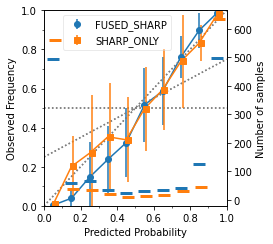

In [13]:
rd

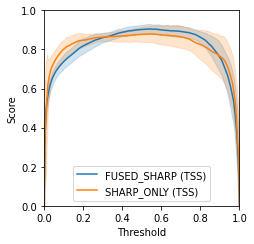

In [14]:
ssp_tss

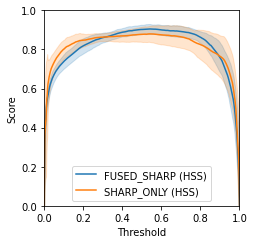

In [15]:
ssp_hss

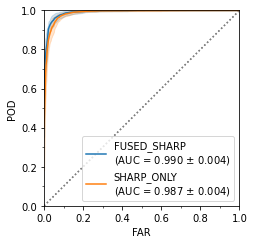

In [16]:
roc

In [17]:
## Figure 5: CNN
rd, ssp_tss, ssp_hss, roc = graphical_compare_dataset(
    base_exp_name, base_run_name,
    ['fused_sharp', 'CNN', 'FUSED_SHARP'],
    ['sharp', 'CNN', 'SHARP_ONLY'],
    f'{output_dir}/sharp_CNN',
    correct_prob=correct_prob,
)

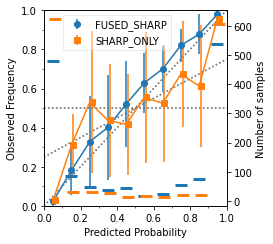

In [18]:
rd

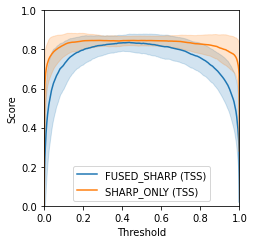

In [19]:
ssp_tss

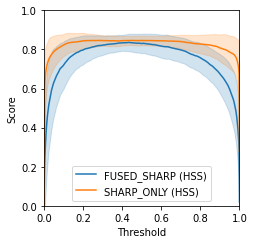

In [20]:
ssp_hss

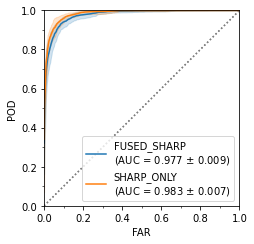

In [21]:
roc

### Figure 6
FUSED_SMARP > SMARP

In [22]:
rd, ssp_tss, ssp_hss, roc = graphical_compare_dataset(
    base_exp_name, base_run_name,
    ['fused_smarp', 'LSTM', 'FUSED_SMARP'],
    ['smarp', 'LSTM', 'SMARP_ONLY'],
    f'{output_dir}/smarp_LSTM',
    correct_prob=correct_prob,
)

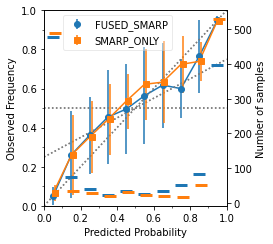

In [32]:
rd

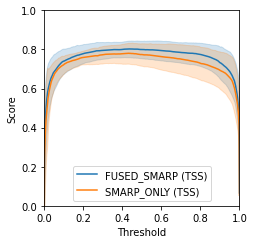

In [33]:
ssp_tss

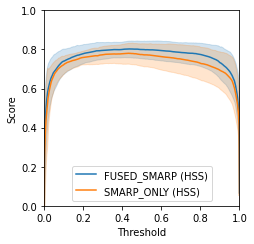

In [34]:
ssp_hss

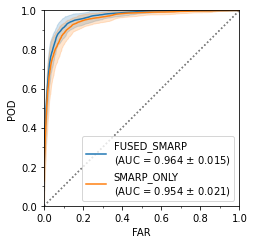

In [35]:
roc

In [36]:
rd, ssp_tss, ssp_hss, roc = graphical_compare_dataset(
    base_exp_name, base_run_name,
    ['fused_smarp', 'CNN', 'FUSED_SMARP'],
    ['smarp', 'CNN', 'SMARP_ONLY'],
    f'{output_dir}/smarp_CNN',
    correct_prob=correct_prob,
)

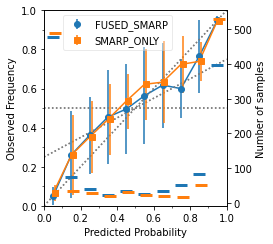

In [37]:
rd

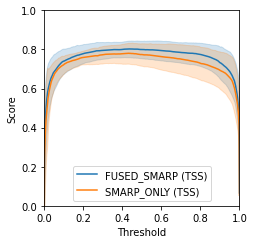

In [38]:
ssp_tss

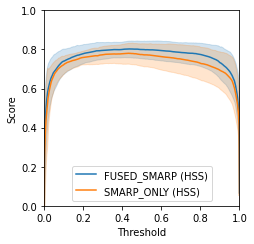

In [39]:
ssp_hss

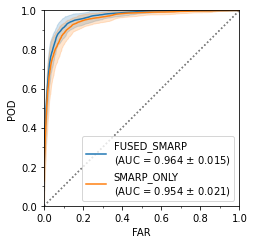

In [40]:
roc

## Sec 4.2

### Table 8

In [41]:
df_pvalues_est = tabulate_pvalues_estimator(runs, metrics=metrics)
df_ttest_est = organize_pvalues_estimator(df_pvalues_est)
style_pvalues_estimator(df_ttest_est)

In [42]:
dfi.export(style_pvalues_estimator(df_ttest_est), f'{output_dir}/Table_8.png')

[0310/004908.794830:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0310/004910.614615:INFO:headless_shell.cc(653)] Written to file /tmp/tmpv6ckosd8/temp.png.


In [43]:
print(typeset(df_ttest_est, escape=False, column_format='c' * (df_ttest_est.shape[1]+1)))

\begin{tabular}{ccccccccc}
\toprule
Dataset & \multicolumn{2}{c}{$\texttt{FUSED\_SHARP}$} & \multicolumn{2}{c}{$\texttt{SHARP\_ONLY}$} & \multicolumn{2}{c}{$\texttt{FUSED\_SMARP}$} & \multicolumn{2}{c}{$\texttt{SMARP\_ONLY}$} \\
{} &               $p$-value &       $t$ &              $p$-value &       $t$ &               $p$-value &       $t$ &              $p$-value &       $t$ \\
Metric $S$ &                         &           &                        &           &                         &           &                        &           \\
\midrule
ACC        &                0.001895 &  3.869861 &               0.040503 &  1.964877 &                0.475229 &  0.063885 &               0.028611 &  2.179500 \\
AUC        &                0.000195 &  5.480629 &               0.047278 &  1.868285 &                0.381100 &  0.311928 &               0.007831 &  2.971610 \\
BSS        &                0.001161 &  4.195644 &               0.041615 &  1.948020 &                0.819610 & 

### Figure 7

In [44]:
graphical_compare_dataset(
    base_exp_name, base_run_name,
    ['fused_sharp', 'LSTM', 'LSTM'],
    ['fused_sharp', 'CNN', 'CNN'],
    f'{output_dir}/model_comp_fused_sharp',
    correct_prob=correct_prob,
)

/home/zeyusun/work/flare-prediction-smarp/arnet/utils/visualization.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(5, 4.5))


(<Figure size 280.8x252 with 2 Axes>,
 <Figure size 252x252 with 1 Axes>,
 <Figure size 252x252 with 1 Axes>,
 <Figure size 252x252 with 1 Axes>)

## Sec 4.3

In [45]:
# # Fit stacking weights
# run_meta_learn(
#     base_experiment_name=base_exp_name, base_run_name=base_run_name,
#     meta_run_name=meta_run_name,
# )

In [75]:
fig, fig_alpha, dfs = meta_learn_show_results(
    run_name=meta_run_name,
    group_col='params.dataset0',
    rep_col='params.seed0',
    criterion_eval='acc', # no tss
    criteria_opt=[
        'CNN', 'LSTM',             
        'AVG', 'BEST',             
        #'hinge',                  
        'cross_entropy',           
        'bss', 'auc', 'tss', 'hss',
        'acc', #'f1', 'bss', 'auc',
    ],
    return_dfs=['df_styled'],
    folder=output_dir
)

In [63]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


### Figure 8, 9

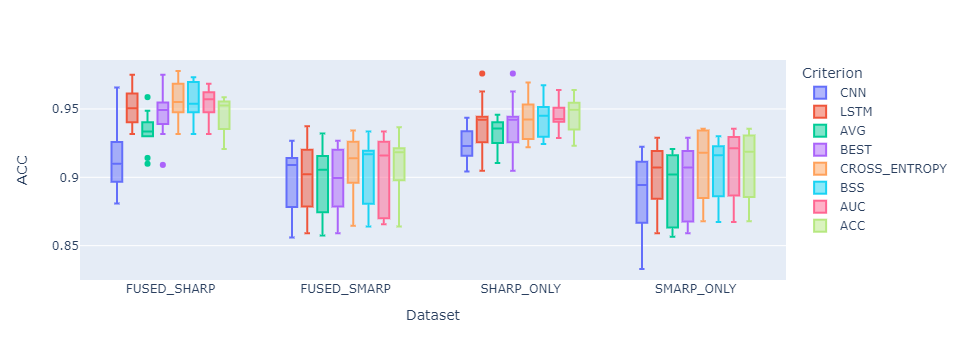

In [76]:
fig.write_image('poster/stacking.png')
fig

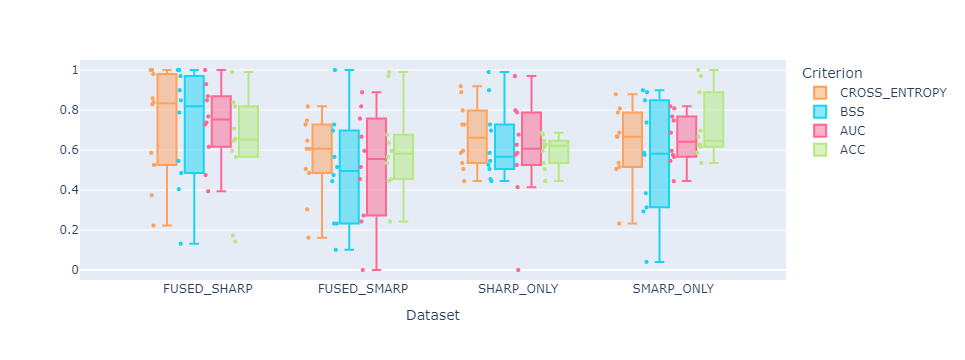

In [77]:
fig_alpha.write_image('poster/stacking_weights.png')
fig_alpha

In [72]:
dfs['df_styled']

### Figure 10

In [74]:
fig_train, fig_val, fig_test, fig_alpha_grid = meta_learn_show_instance(
    base_exp_name, base_run_name,
    query='smarp/0/acc'
)

> /home/zeyusun/work/flare-prediction-smarp/notebooks/cotrain_helper.py(839)meta_learn_show_instance()
    838     breakpoint()
--> 839     fig_val = plot_level_one_naive(X['val'], y['val'],
    840                                    axis_titles=['LSTM predicted probability', 'CNN predicted probability'],



ipdb>  c


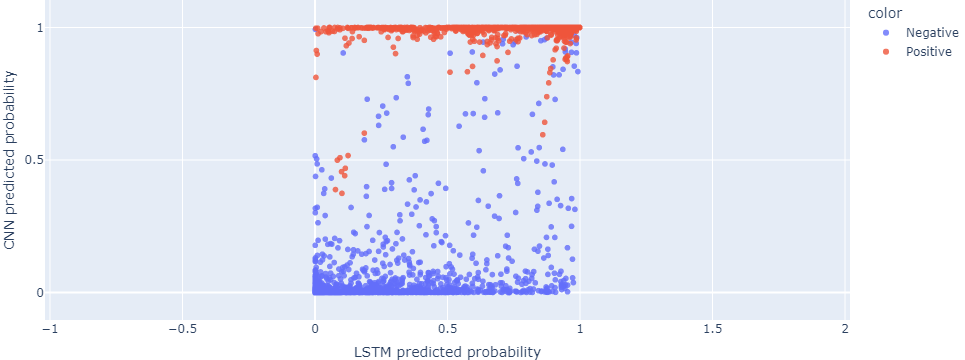

In [80]:
fig_train.write_image(f'{output_dir}/data_train.png')
fig_train

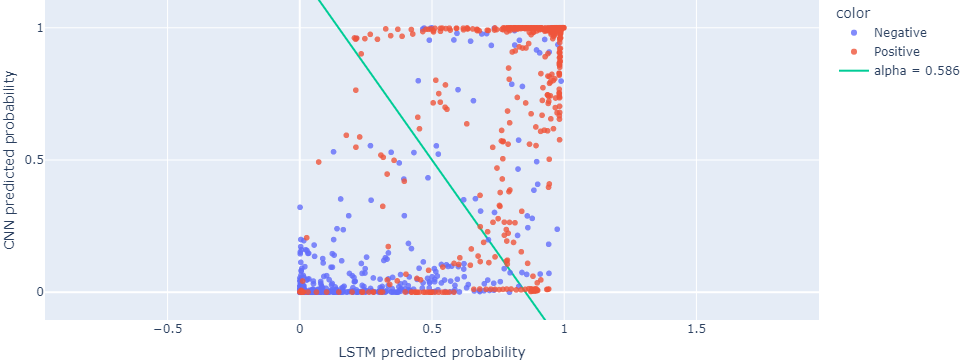

In [82]:
fig_val.write_image(f'{output_dir}/data_val.png')
fig_val

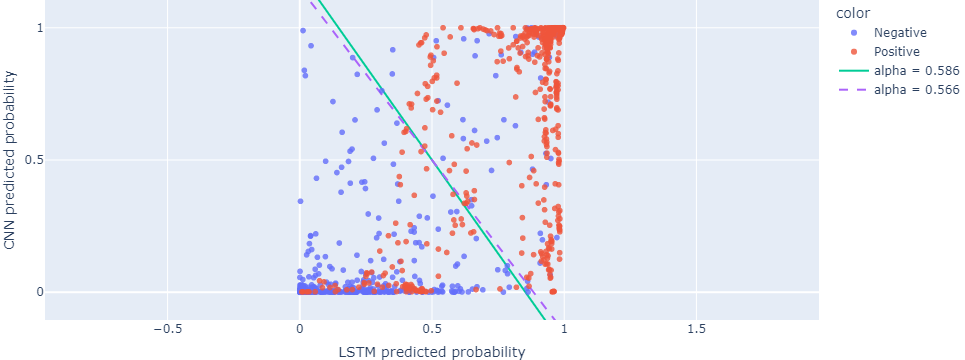

In [83]:
fig_test.write_image(f'{output_dir}/data_test.png')
fig_test

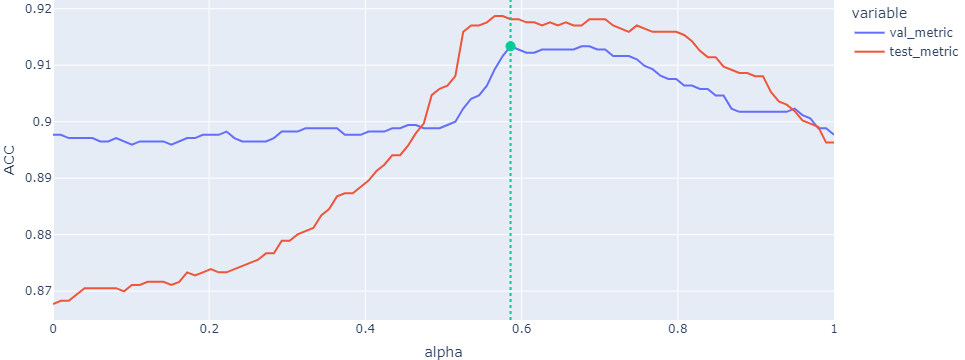

In [84]:
fig_alpha_grid.write_image(f'{output_dir}/alpha.png')
fig_alpha_grid